In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import corner

from cmcrameri import cm
from matplotlib.colors import to_rgba
from pqcd.utils import (
    to_nucleons_per_cubic_femtometre,
    GeV_per_cubic_femtometer_to_dyn_per_square_cm,
)

from plot_utils import (
    rcparams,
    prior_c,
    gp0_pqcd_c,
    gp0_pqcd_ls,
    astro_c,
    gp0_astro_pqcd_mod_c,
    gp0_astro_pqcd_mod_ls,
)
plt.rcParams.update(rcparams)

In [2]:
# GP0 quantities for reference

# Collated EOSs
collated_eos_gp0 = pd.read_csv(
    '../data/eos-draws-default/eos-draws-default.csv',
    index_col='eos'
)

# Quantities at nTOV
ntov_gp0 = to_nucleons_per_cubic_femtometre(collated_eos_gp0['ntov'])
ptov_gp0 = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/pressure_ntov.dat'
)
etov_gp0 = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/energy_density_ntov.dat'
)

# Weights
astro_weights_gp0 = np.exp(
    collated_eos_gp0.logweight_total - collated_eos_gp0.logweight_total.max()
).values
ntov_max_weights_gp0 = np.loadtxt(
    '../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_Xmarg_mu2.6.dat'
)
ntov_marg_weights_gp0 = np.loadtxt(
    '../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_marg.dat'
)

In [3]:
collated_eos_gp1 = pd.read_csv(
    '../data/eos-draws-modified/gp1/eos-draws-modified-gp1.csv',
    index_col='eos'
)

collated_eos_gp2 = pd.read_csv(
    '../data/eos-draws-modified/gp2/eos-draws-modified-gp2.csv',
    index_col='eos'
)

In [4]:
astro_weights_gp1 = np.exp(
    collated_eos_gp1.logweight_total - collated_eos_gp1.logweight_total.max()
).values

astro_weights_gp2 = np.exp(
    collated_eos_gp2.logweight_total - collated_eos_gp2.logweight_total.max()
).values

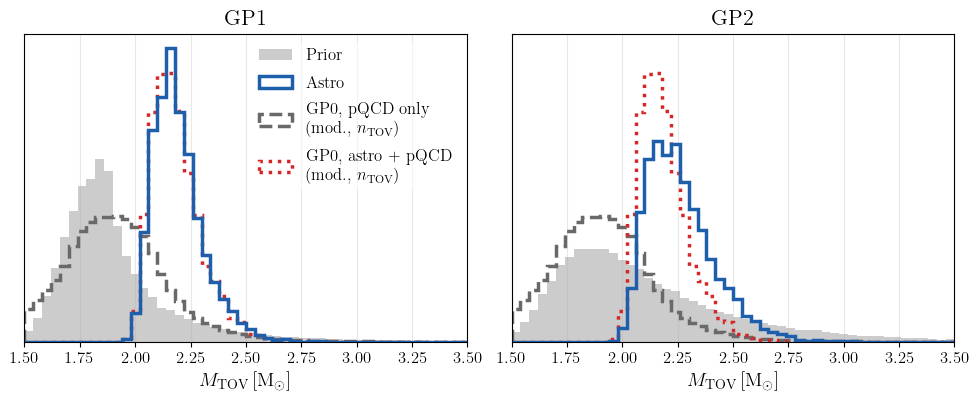

In [5]:
lw = 2.5

titles = ['GP1', 'GP2']

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)

for i, ax in enumerate(axs):
    ax.grid(alpha=0.3)
    ax.set_title(titles[i], fontsize=16)

hist_kwargs = dict(
    bins=50,
    density=True,
    linewidth=lw
)

# GP1 and GP2 Prior
# -----------------

axs[0].hist(
    collated_eos_gp1['Mmax'], 
    color=prior_c,
    range=(1.5, 3.5),
    **hist_kwargs
)
axs[1].hist(
    collated_eos_gp2['Mmax'], 
    color=prior_c,
    range=(1.5, 3.5),
    **hist_kwargs
)

# GP0 pQCD-only
# -------------

for ax in axs:
    ax.hist(
        collated_eos_gp0['Mmax'],
        weights=ntov_marg_weights_gp0,
        color=gp0_pqcd_c,
        linestyle=gp0_pqcd_ls,
        histtype='step',
        range=(1.5, 3.5),
        **hist_kwargs
    )

# GP0 astro+pQCD
# --------------

for ax in axs:
    ax.hist(
        collated_eos_gp0['Mmax'],
        weights=astro_weights_gp0*ntov_marg_weights_gp0,
        color=gp0_astro_pqcd_mod_c,
        linestyle=gp0_astro_pqcd_mod_ls,
        histtype='step',
        range=(1.5, 3.5),
        **hist_kwargs
    )

# GP1 and GP2 Astro
# -----------------

axs[0].hist(
    collated_eos_gp1['Mmax'], 
    weights=astro_weights_gp1, 
    color=astro_c,
    histtype='step',
    range=(1.5, 3.5),
    **hist_kwargs
)
axs[1].hist(
    collated_eos_gp2['Mmax'], 
    weights=astro_weights_gp2, 
    color=astro_c,
    histtype='step',
    range=(1.5, 3.5),
    **hist_kwargs
)

handles = [
    mpatches.Patch(color=prior_c, linewidth=0),
    mpatches.Patch(edgecolor=astro_c, fill=False, linewidth=lw),
    mpatches.Patch(
        edgecolor=gp0_pqcd_c, fill=False, linewidth=lw, linestyle=gp0_pqcd_ls
    ),
    mpatches.Patch(
        edgecolor=gp0_astro_pqcd_mod_c, 
        fill=False, 
        linewidth=lw, 
        linestyle=gp0_astro_pqcd_mod_ls
    )
]
labels = [
    'Prior',
    'Astro',
    'GP0, pQCD only \n(mod., $n_\mathrm{TOV}$)',
    'GP0, astro + pQCD \n(mod., $n_\mathrm{TOV}$)'
]
l = axs[0].legend(
    handles,
    labels,
    loc='upper right',
    labelspacing=0.75,
)
l.get_frame().set_alpha(None)
l.get_frame().set_edgecolor((0, 0, 0, 0.))
l.get_frame().set_facecolor((1, 1, 1, 0.5))

axs[0].set_xlim(1.5, 3.5)
axs[0].set_yticks([])

for ax in axs:
    ax.set_xlabel(r'$M_\mathrm{TOV}\,[\mathrm{M}_\odot]$')

fig.savefig('figures/paper/m_tov_gp1_gp2.pdf', bbox_inches='tight')

In [6]:
from pqcd.utils import weighted_quantile

In [7]:
q5, q50, q95 = weighted_quantile(
    collated_eos_gp0['Mmax'].values,
    [0.05, 0.5, 0.95],
    astro_weights_gp0*ntov_marg_weights_gp0,
)
print(f'GP0: {q5:.2f} {q50:.2f} {q95:.2f}')
print(f'{q50:.2f} + {q95-q50:.2f} - {q50-q5:.2f}')

GP0: 2.04 2.17 2.40
2.17 + 0.23 - 0.13


In [8]:
q5, q50, q95 = weighted_quantile(
    collated_eos_gp1['Mmax'], (0.05, 0.5, 0.95), astro_weights_gp1, 
)
print(f'GP1: 5th, 50th, 95th percentiles: {q5}, {q50}, {q95}')
print(f'{q50:.2f} + {q95-q50:.2f} - {q50-q5:.2f}')

GP1: 5th, 50th, 95th percentiles: 2.044492377872714, 2.1756452599400764, 2.4079561605457878
2.18 + 0.23 - 0.13


In [9]:
q5, q50, q95 = weighted_quantile(
    collated_eos_gp2['Mmax'], (0.05, 0.5, 0.95), astro_weights_gp2, 
)
print(f'GP1: 5th, 50th, 95th percentiles: {q5}, {q50}, {q95}')
print(f'{q50:.2f} + {q95-q50:.2f} - {q50-q5:.2f}')

GP1: 5th, 50th, 95th percentiles: 2.067459292167965, 2.235648899921807, 2.542087277070495
2.24 + 0.31 - 0.17


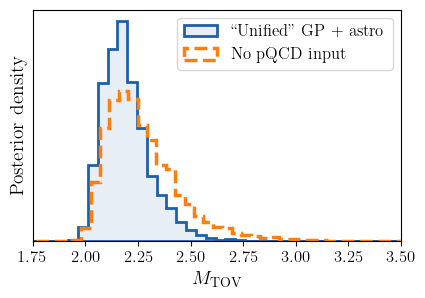

In [10]:
fig, ax = plt.subplots(figsize=(4.75,3))

ax.hist(
    collated_eos_gp1['Mmax'], 
    weights=astro_weights_gp1, 
    histtype='stepfilled',
    facecolor=list(to_rgba(astro_c))[:3] + [0.1],
    edgecolor=astro_c,
    bins=100, 
    density=True,
    linewidth=2,
    label="``Unified'' GP + astro"
)

ax.hist(
    collated_eos_gp0['Mmax'],
    weights=astro_weights_gp0, 
    histtype='step',
    bins=100, 
    density=True,
    linewidth=2.5,
    linestyle='--',
    label="No pQCD input"
)

ax.set_xlim(1.75, 3.5)

ax.set_yticks([])

ax.set_xlabel('$M_\mathrm{TOV}$')
ax.set_ylabel('Posterior density')

ax.legend()

fig.savefig('figures/presentation/mtov_post.png', bbox_inches='tight')

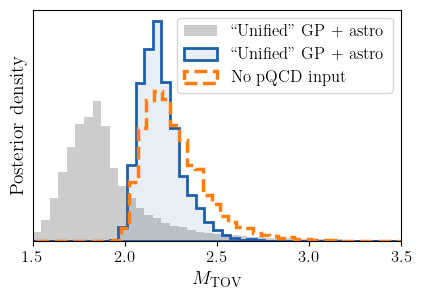

In [11]:
fig, ax = plt.subplots(figsize=(4.75,3))

ax.hist(
    collated_eos_gp1['Mmax'], 
    histtype='stepfilled',
    color=prior_c,
    bins=100, 
    density=True,
    linewidth=2,
    label="``Unified'' GP + astro"
)

ax.hist(
    collated_eos_gp1['Mmax'], 
    weights=astro_weights_gp1, 
    histtype='stepfilled',
    facecolor=list(to_rgba(astro_c))[:3] + [0.1],
    edgecolor=astro_c,
    bins=100, 
    density=True,
    linewidth=2,
    label="``Unified'' GP + astro"
)

ax.hist(
    collated_eos_gp0['Mmax'],
    weights=astro_weights_gp0, 
    histtype='step',
    bins=100, 
    density=True,
    linewidth=2.5,
    linestyle='--',
    label="No pQCD input"
)

ax.set_xlim(1.5, 3.5)

ax.set_yticks([])

ax.set_xlabel('$M_\mathrm{TOV}$')
ax.set_ylabel('Posterior density')

ax.legend();

In [12]:
ntov_gp1 = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantities_at_n/density_ntov.dat'
)

ptov_gp1 = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantities_at_n/pressure_ntov.dat'
)

etov_gp1 = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantities_at_n/energy_density_ntov.dat'
)

ntov_gp2 = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantities_at_n/density_ntov.dat'
)

ptov_gp2 = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantities_at_n/pressure_ntov.dat'
)

etov_gp2 = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantities_at_n/energy_density_ntov.dat'
)

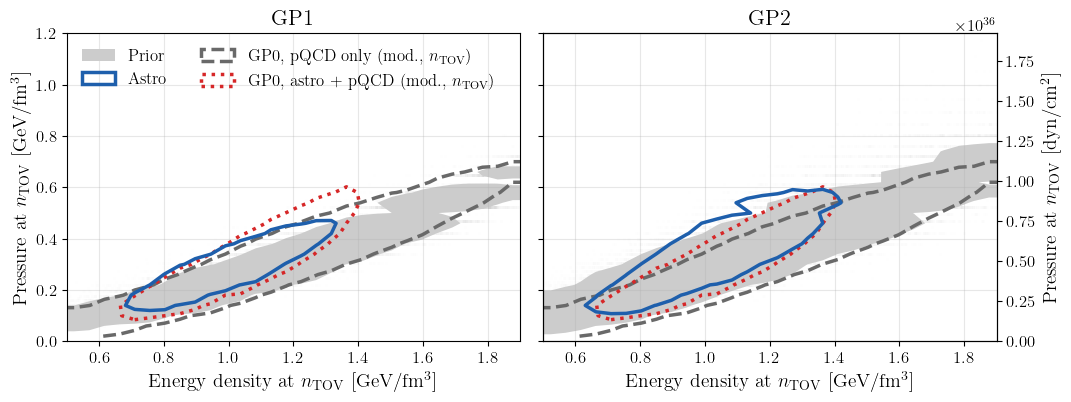

In [13]:
lw = 2.5

eps_lim = (0.5, 1.9)
p_lim = (0, 1.2)

hist_kwargs = dict(
    bins=30,
    levels=[0.9],
    smooth=0.5,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=True,
    range=[eps_lim, p_lim]
)

titles = [
    'GP1', 
    'GP2'
]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.05)

for i, ax in enumerate(axs):
    ax.grid(alpha=0.3)
    ax.set_title(titles[i], fontsize=16)

# GP1 prior
corner.hist2d(
    etov_gp1, 
    ptov_gp1, 
    ax=axs[0],
    color=prior_c,
    plot_datapoints=True,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'colors': prior_c, 'antialiased': True},
    **hist_kwargs
)

# GP2 prior
corner.hist2d(
    etov_gp2, 
    ptov_gp2, 
    ax=axs[1],
    color=prior_c,
    plot_datapoints=True,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'colors': prior_c, 'antialiased': True},
    **hist_kwargs
)

# GP0 pQCD-only
for ax in axs:
    corner.hist2d(
        etov_gp0, 
        ptov_gp0, 
        ax=ax,
        weights=ntov_marg_weights_gp0, 
        color=gp0_pqcd_c,
        plot_datapoints=False,
        contour_kwargs={'linewidths': lw, 'linestyles': gp0_pqcd_ls},
        contourf_kwargs={'alpha': 0},
        **hist_kwargs
    )

# GP0 astro+pQCD
for ax in axs:
    corner.hist2d(
        etov_gp0, 
        ptov_gp0, 
        ax=ax,
        weights=ntov_marg_weights_gp0*astro_weights_gp0, 
        color=gp0_astro_pqcd_mod_c,
        plot_datapoints=False,
        contour_kwargs={'linewidths': lw, 'linestyles': gp0_astro_pqcd_mod_ls},
        contourf_kwargs={'alpha': 0},
        **hist_kwargs
    )

# GP1 astro
corner.hist2d(
    etov_gp1, 
    ptov_gp1, 
    ax=axs[0],
    weights=astro_weights_gp1, 
    color=astro_c,
    plot_datapoints=False,
    contour_kwargs={'linewidths': lw},
    contourf_kwargs={'alpha': 0},
    **hist_kwargs
)

# GP2 astro
corner.hist2d(
    etov_gp2, 
    ptov_gp2, 
    ax=axs[1],
    weights=astro_weights_gp2, 
    color=astro_c,
    plot_datapoints=False,
    contour_kwargs={'linewidths': lw},
    contourf_kwargs={'alpha': 0},
    **hist_kwargs
)

# ---

handles = [
    mpatches.Patch(color=prior_c, linewidth=0),
    mpatches.Patch(edgecolor=astro_c, fill=False, linewidth=lw),
    mpatches.Patch(
        edgecolor=gp0_pqcd_c, fill=False, linewidth=lw, linestyle=gp0_pqcd_ls
    ),
    mpatches.Patch(
        edgecolor=gp0_astro_pqcd_mod_c, 
        fill=False, 
        linewidth=lw, 
        linestyle=gp0_astro_pqcd_mod_ls
    )
]
labels = [
    'Prior',
    'Astro',
    'GP0, pQCD only (mod., $n_\mathrm{TOV}$)',
    'GP0, astro + pQCD (mod., $n_\mathrm{TOV}$)'
]
axs[0].legend(
    handles,
    labels,
    loc='upper left',
    frameon=False,
    ncol=2
)

# ---
    
twinx = axs[1].twinx()
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [dyn/cm$^2$]')

for ax in axs:
    ax.set_xlabel(r'Energy density at $n_\mathrm{TOV}$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [GeV/fm$^3$]')

fig.savefig('figures/paper/p_eps_tov_gp1_gp2.pdf', bbox_inches='tight')

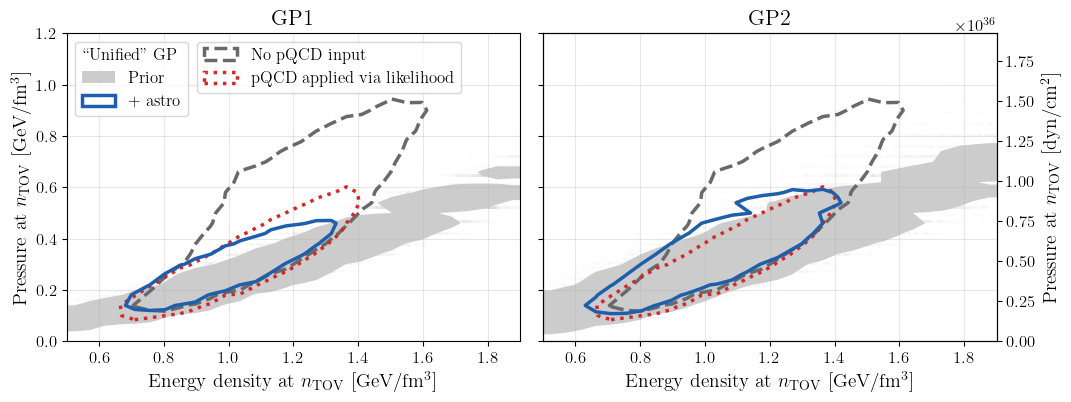

In [14]:
lw = 2.5

eps_lim = (0.5, 1.9)
p_lim = (0, 1.2)

hist_kwargs = dict(
    bins=30,
    levels=[0.9],
    smooth=0.5,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=True,
    range=[eps_lim, p_lim]
)

titles = [
    'GP1', 
    'GP2'
]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.05)

for i, ax in enumerate(axs):
    ax.grid(alpha=0.3)
    ax.set_title(titles[i], fontsize=16)

# GP1 prior
corner.hist2d(
    etov_gp1, 
    ptov_gp1, 
    ax=axs[0],
    color=prior_c,
    plot_datapoints=True,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'colors': prior_c, 'antialiased': True},
    **hist_kwargs
)

# GP2 prior
corner.hist2d(
    etov_gp2, 
    ptov_gp2, 
    ax=axs[1],
    color=prior_c,
    plot_datapoints=True,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'colors': prior_c, 'antialiased': True},
    **hist_kwargs
)

for ax in axs:

    # No pQCD
    corner.hist2d(
        etov_gp0, 
        ptov_gp0, 
        ax=ax,
        weights=astro_weights_gp0, 
        color=gp0_pqcd_c,
        plot_datapoints=False,
        contour_kwargs={'linewidths': lw, 'linestyles': gp0_pqcd_ls},
        contourf_kwargs={'alpha': 0},
        **hist_kwargs
    )

    # GP0 astro+pQCD (pQCD via likelihood)
    corner.hist2d(
        etov_gp0, 
        ptov_gp0, 
        ax=ax,
        weights=ntov_marg_weights_gp0*astro_weights_gp0, 
        color=gp0_astro_pqcd_mod_c,
        plot_datapoints=False,
        contour_kwargs={'linewidths': lw, 'linestyles': gp0_astro_pqcd_mod_ls},
        contourf_kwargs={'alpha': 0},
        **hist_kwargs
    )

# GP1 astro
corner.hist2d(
    etov_gp1, 
    ptov_gp1, 
    ax=axs[0],
    weights=astro_weights_gp1, 
    color=astro_c,
    plot_datapoints=False,
    contour_kwargs={'linewidths': lw},
    contourf_kwargs={'alpha': 0},
    **hist_kwargs
)

# GP2 astro
corner.hist2d(
    etov_gp2, 
    ptov_gp2, 
    ax=axs[1],
    weights=astro_weights_gp2, 
    color=astro_c,
    plot_datapoints=False,
    contour_kwargs={'linewidths': lw},
    contourf_kwargs={'alpha': 0},
    **hist_kwargs
)

# ---

handles = [
    mpatches.Patch(color=prior_c, linewidth=0),
    mpatches.Patch(edgecolor=astro_c, fill=False, linewidth=lw),
]

labels = [
    'Prior',
    '+ astro',
]

l1 = axs[0].legend(
    handles,
    labels,
    loc='upper left',
    ncol=1,
    title_fontsize=12,
    title="``Unified'' GP"
)

axs[0].add_artist(l1)

handles = [
    mpatches.Patch(
        edgecolor=gp0_pqcd_c, fill=False, linewidth=lw, linestyle=gp0_pqcd_ls
    ),
    mpatches.Patch(
        edgecolor=gp0_astro_pqcd_mod_c, 
        fill=False, 
        linewidth=lw, 
        linestyle=gp0_astro_pqcd_mod_ls
    )
]

labels = [
    'No pQCD input',
    'pQCD applied via likelihood',
]

axs[0].legend(
    handles,
    labels,
    loc='upper left',
    ncol=1,
    title_fontsize=12,
    bbox_to_anchor=(0.27,1)
)

# ---
    
twinx = axs[1].twinx()
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [dyn/cm$^2$]')

for ax in axs:
    ax.set_xlabel(r'Energy density at $n_\mathrm{TOV}$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [GeV/fm$^3$]')

fig.savefig('figures/presentation/p_eps_tov_gp1_gp2.png', bbox_inches='tight', dpi=300)

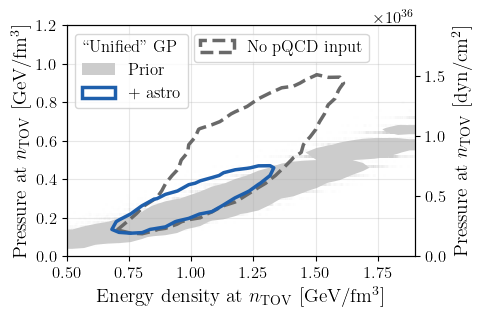

In [15]:
lw = 2.5

eps_lim = (0.5, 1.9)
p_lim = (0, 1.2)

hist_kwargs = dict(
    bins=30,
    levels=[0.9],
    smooth=0.5,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=True,
    range=[eps_lim, p_lim]
)

fig, ax = plt.subplots(figsize=(4.5, 3))

ax.grid(alpha=0.3)

# GP1 prior
corner.hist2d(
    etov_gp1, 
    ptov_gp1, 
    ax=ax,
    color=prior_c,
    plot_datapoints=True,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'colors': prior_c, 'antialiased': True},
    **hist_kwargs
)

# No pQCD
corner.hist2d(
    etov_gp0, 
    ptov_gp0, 
    ax=ax,
    weights=astro_weights_gp0, 
    color=gp0_pqcd_c,
    plot_datapoints=False,
    contour_kwargs={'linewidths': lw, 'linestyles': gp0_pqcd_ls},
    contourf_kwargs={'alpha': 0},
    **hist_kwargs
)

# GP1 astro
corner.hist2d(
    etov_gp1, 
    ptov_gp1, 
    ax=ax,
    weights=astro_weights_gp1, 
    color=astro_c,
    plot_datapoints=False,
    contour_kwargs={'linewidths': lw},
    contourf_kwargs={'alpha': 0},
    **hist_kwargs
)

# ---

handles = [
    mpatches.Patch(color=prior_c, linewidth=0),
    mpatches.Patch(edgecolor=astro_c, fill=False, linewidth=lw),
]

labels = [
    'Prior',
    '+ astro',
]

l1 = ax.legend(
    handles,
    labels,
    loc='upper left',
    ncol=1,
    title_fontsize=12,
    title="``Unified'' GP"
)

ax.add_artist(l1)

handles = [
    mpatches.Patch(
        edgecolor=gp0_pqcd_c, fill=False, linewidth=lw, linestyle=gp0_pqcd_ls
    ),
]

labels = [
    'No pQCD input',
]

ax.legend(
    handles,
    labels,
    loc='upper left',
    ncol=1,
    title_fontsize=12,
    bbox_to_anchor=(0.34,1)
)

# ---
    
twinx = ax.twinx()
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(ax.get_ylim())))
twinx.set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [dyn/cm$^2$]')

ax.set_xlabel(r'Energy density at $n_\mathrm{TOV}$ [GeV/fm$^3$]')
ax.set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [GeV/fm$^3$]')

fig.savefig('figures/presentation/p_eps_tov_gp1.png', bbox_inches='tight', dpi=300)

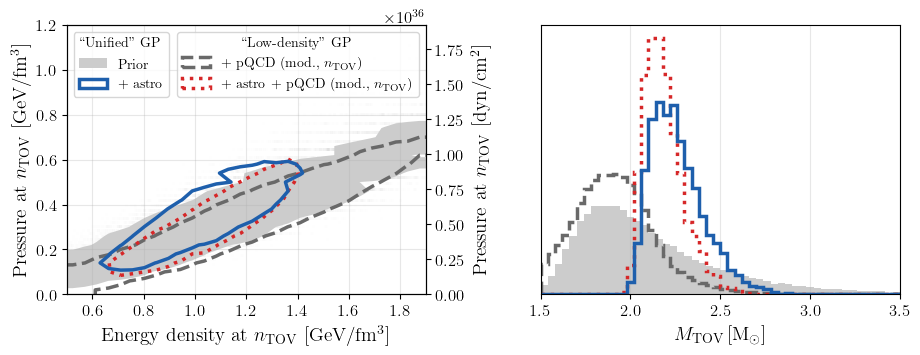

In [16]:
lw = 2.5

eps_lim = (0.5, 1.9)
p_lim = (0, 1.2)

hist_kwargs = dict(
    bins=30,
    levels=[0.9],
    smooth=0.5,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=True,
    range=[eps_lim, p_lim]
)

hist_1d_kwargs = dict(
    bins=50,
    density=True,
    linewidth=lw
)

fig, axs = plt.subplots(1, 2, figsize=(10.75, 3.5))
fig.subplots_adjust(wspace=0.32)

for i, ax in enumerate(axs):
    ax.grid(alpha=0.3)

# pressure vs epsilon
# -------------------

# GP2 prior
corner.hist2d(
    etov_gp2, 
    ptov_gp2, 
    ax=axs[0],
    color=prior_c,
    plot_datapoints=True,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'colors': prior_c, 'antialiased': True},
    **hist_kwargs
)

# GP0 pQCD-only
corner.hist2d(
    etov_gp0, 
    ptov_gp0, 
    ax=axs[0],
    weights=ntov_marg_weights_gp0, 
    color=gp0_pqcd_c,
    plot_datapoints=False,
    contour_kwargs={'linewidths': lw, 'linestyles': gp0_pqcd_ls},
    contourf_kwargs={'alpha': 0},
    **hist_kwargs
)

# GP0 astro+pQCD
corner.hist2d(
    etov_gp0, 
    ptov_gp0, 
    ax=axs[0],
    weights=ntov_marg_weights_gp0*astro_weights_gp0, 
    color=gp0_astro_pqcd_mod_c,
    plot_datapoints=False,
    contour_kwargs={'linewidths': lw, 'linestyles': gp0_astro_pqcd_mod_ls},
    contourf_kwargs={'alpha': 0},
    **hist_kwargs
)

# GP2 astro
corner.hist2d(
    etov_gp2, 
    ptov_gp2, 
    ax=axs[0],
    weights=astro_weights_gp2, 
    color=astro_c,
    plot_datapoints=False,
    contour_kwargs={'linewidths': lw},
    contourf_kwargs={'alpha': 0},
    **hist_kwargs
)

# mass
# ----

# GP2 Prior
# ---------

axs[1].hist(
    collated_eos_gp2['Mmax'], 
    color=prior_c,
    range=(1.5, 3.5),
    **hist_1d_kwargs
)

# GP0 pQCD-only
# -------------

axs[1].hist(
    collated_eos_gp0['Mmax'],
    weights=ntov_marg_weights_gp0,
    color=gp0_pqcd_c,
    linestyle=gp0_pqcd_ls,
    histtype='step',
    range=(1.5, 3.5),
    **hist_1d_kwargs
)

# GP0 astro+pQCD
# --------------

ax.hist(
    collated_eos_gp0['Mmax'],
    weights=astro_weights_gp0*ntov_marg_weights_gp0,
    color=gp0_astro_pqcd_mod_c,
    linestyle=gp0_astro_pqcd_mod_ls,
    histtype='step',
    range=(1.5, 3.5),
    **hist_1d_kwargs
)

# GP2 Astro
# ---------

axs[1].hist(
    collated_eos_gp2['Mmax'], 
    weights=astro_weights_gp2, 
    color=astro_c,
    histtype='step',
    range=(1.5, 3.5),
    **hist_1d_kwargs
)

# ---

handles = [
    mpatches.Patch(color=prior_c, linewidth=0),
    mpatches.Patch(edgecolor=astro_c, fill=False, linewidth=lw),
]
labels = [
    'Prior',
    '+ astro',
]
l1 = axs[0].legend(
    handles,
    labels,
    loc='upper left',
    ncol=1,
    title_fontsize=10,
    title="``Unified'' GP",
    fontsize=10,
    labelspacing=0.6,
)
axs[0].add_artist(l1)

handles = [
    mpatches.Patch(
        edgecolor=gp0_pqcd_c, fill=False, linewidth=lw, linestyle=gp0_pqcd_ls
    ),
    mpatches.Patch(
        edgecolor=gp0_astro_pqcd_mod_c, 
        fill=False, 
        linewidth=lw, 
        linestyle=gp0_astro_pqcd_mod_ls
    )
]
labels = [
    '+ pQCD (mod., $n_\mathrm{TOV}$)',
    '+ astro + pQCD (mod., $n_\mathrm{TOV}$)'
]
l2 = axs[0].legend(
    handles,
    labels,
    loc='upper right',
    ncol=1,
    title_fontsize=10,
    title="``Low-density'' GP",
    fontsize=10
)

# ---
    
twinx = axs[0].twinx()
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [dyn/cm$^2$]')

axs[0].set_xlabel(r'Energy density at $n_\mathrm{TOV}$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [GeV/fm$^3$]')

axs[1].set_xlim(1.5, 3.5)
axs[1].set_yticks([])

axs[1].set_xlabel(r'$M_\mathrm{TOV}\,[\mathrm{M}_\odot]$')

fig.savefig('figures/paper/p_eps_M_tov_gp2.pdf', bbox_inches='tight')

In [17]:
q5, q50, q95 = weighted_quantile(
    ptov_gp0, (0.05, 0.5, 0.95), astro_weights_gp0*ntov_marg_weights_gp0
)
print(f'GP0: 5th, 50th, 95th percentiles: {q5}, {q50}, {q95}')
print(f'{q50:.2f} + {q95-q50:.2f} - {q50-q5:.2f}')

GP0: 5th, 50th, 95th percentiles: 0.1451499335037075, 0.2888493998279649, 0.5309500494583168
0.29 + 0.24 - 0.14


In [18]:
q5, q50, q95 = weighted_quantile(
    ptov_gp2, (0.05, 0.5, 0.95), astro_weights_gp2
)
print(f'GP2: 5th, 50th, 95th percentiles: {q5}, {q50}, {q95}')
print(f'{q50:.2f} + {q95-q50:.2f} - {q50-q5:.2f}')

GP2: 5th, 50th, 95th percentiles: 0.1773907672454595, 0.33898541439999985, 0.5509580236566306
0.34 + 0.21 - 0.16


In [19]:
q95_unified = weighted_quantile(
    ptov_gp2, (0.95), astro_weights_gp2
)
q95_ld = weighted_quantile(
    ptov_gp0, (0.95), astro_weights_gp0
)

In [20]:
q95_unified, q95_ld

(0.5509580236566306, 0.8463811767295528)

In [21]:
(q95_ld - q95_unified)/q95_ld

0.3490426786361765